In [1]:
from OptionPricing import *
from AnalyticFormulas import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from functools import partial
import time

Test


# Black Scholes Model

In [2]:
r = 0.03
sigma = 0.3
s = 100
T = 1.
model = BlackScholesModel(sigma, r, s, T)
strikes = np.linspace(20, 200, 10000)
moneyness = s / strikes

def call(x, strike): return np.maximum(x - strike, 0)
calls = [partial(call, strike=k) for k in strikes]
prices = model.OptionPricePayOffRangeMC(calls, s, T)
analyticPrices = np.array([blackScholesPrice(s, r, sigma, T, k) for k in strikes])
pricesNorm = prices / strikes
analyticPricesNorm = analyticPrices / strikes

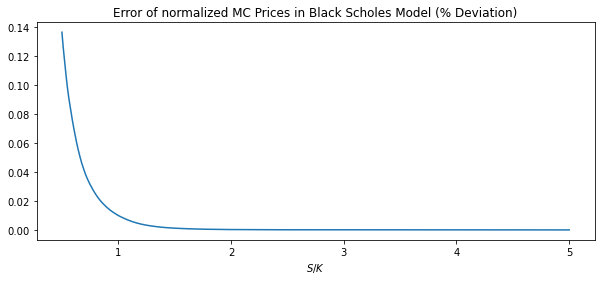

In [3]:
plt.figure(figsize=(10,4))
plt.plot(moneyness, (pricesNorm - analyticPricesNorm) / analyticPricesNorm)
plt.title('Error of normalized MC Prices in Black Scholes Model (% Deviation)')
plt.xlabel('$S/K$')
plt.show()

## Neural Net

In [4]:
X = np.reshape(moneyness, (len(moneyness), 1))
y = analyticPricesNorm
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

C:\Users\oli-w\AppData\Local\Temp/ipykernel_6832/4173135874.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bestLoss = np.float('inf')


Batch Size: 50
Learning Rate: 0.1
Training Time: 2.1684787273406982 seconds
Batch Size: 50
Learning Rate: 0.01
Training Time: 2.7398228645324707 seconds
Batch Size: 50
Learning Rate: 0.001
Training Time: 6.398792743682861 seconds
Batch Size: 50
Learning Rate: 0.0001
Training Time: 25.21005916595459 seconds
Batch Size: 100
Learning Rate: 0.1
Training Time: 1.2379536628723145 seconds
Batch Size: 100
Learning Rate: 0.01
Training Time: 3.12707781791687 seconds
Batch Size: 100
Learning Rate: 0.001
Training Time: 10.308868646621704 seconds
Batch Size: 100
Learning Rate: 0.0001
Training Time: 30.525933504104614 seconds
Batch Size: 300
Learning Rate: 0.1
Training Time: 1.9851057529449463 seconds
Batch Size: 300
Learning Rate: 0.01
Training Time: 2.0342042446136475 seconds
Batch Size: 300
Learning Rate: 0.001
Training Time: 11.664069175720215 seconds
Batch Size: 300
Learning Rate: 0.0001
Training Time: 20.83749771118164 seconds
Batch Size: 700
Learning Rate: 0.1
Training Time: 2.385532140731811

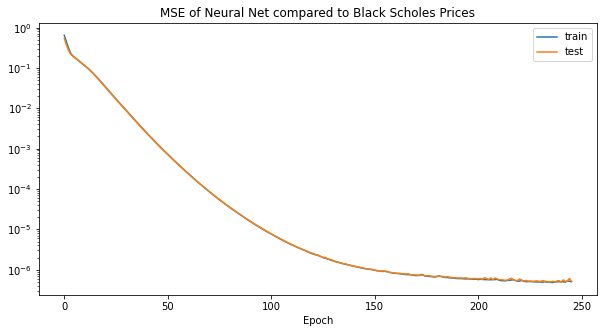

In [5]:
nns = []
hists = []
bestLoss = np.float('inf')
for b in [50, 100, 300, 700, 1200]:
    for l in [0.1, 0.01, 0.001, 0.0001]:
        neuralNet = keras.Sequential([
            keras.layers.Dense(30, activation='relu', input_shape=X.shape[1:]),
            keras.layers.Dense(20, activation='relu'),
            #keras.layers.Dense(10, activation='relu'),
            #keras.layers.Dense(5, activation='relu'),
            keras.layers.Dense(1)
        ])

        earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        neuralNet.compile(optimizer=keras.optimizers.Adam(learning_rate=l), loss='mse')

        start = time.time()
        hist = neuralNet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3000, batch_size=b, verbose=0, callbacks=[earlyStop])
        end = time.time()
        print('Batch Size: {}'.format(b))
        print('Learning Rate: {}'.format(l))
        print('Training Time: {} seconds'.format(end-start))
        loss = neuralNet.evaluate(X_test, y_test, verbose=0)
        nns.append(neuralNet)
        hists.append(hist)
        if loss < bestLoss:
            bestModel = neuralNet
            bestBatch, bestLearn, bestLoss, bestHist = b, l, loss, hist
print('Best Model:')
print('Batch Size: {}'.format(bestBatch))
print('Learning Rate: {}'.format(bestLearn))
print('MSE: {}'.format(bestLoss))
plt.figure(figsize=(10,5))
plt.plot(bestHist.history['loss'], label='train')
plt.plot(bestHist.history['val_loss'], label='test')
plt.yscale('log')
plt.title('MSE of Neural Net compared to Black Scholes Prices')
plt.xlabel('Epoch')
plt.legend()

Text(0.5, 1.0, 'Normalized Call Prices BS vs. Neural Net')

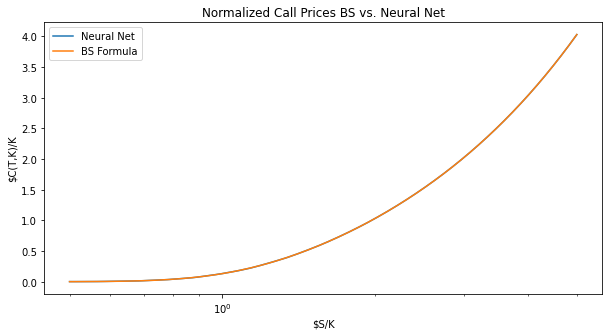

In [8]:
plt.figure(figsize=(10,5))
plt.plot(moneyness, bestModel.predict(X), label='Neural Net')
plt.plot(moneyness, analyticPricesNorm, label='BS Formula')
plt.xlabel('$S/K')
plt.ylabel('$C(T,K)/K')
plt.xscale('log')
plt.legend()
plt.title('Normalized Call Prices BS vs. Neural Net')


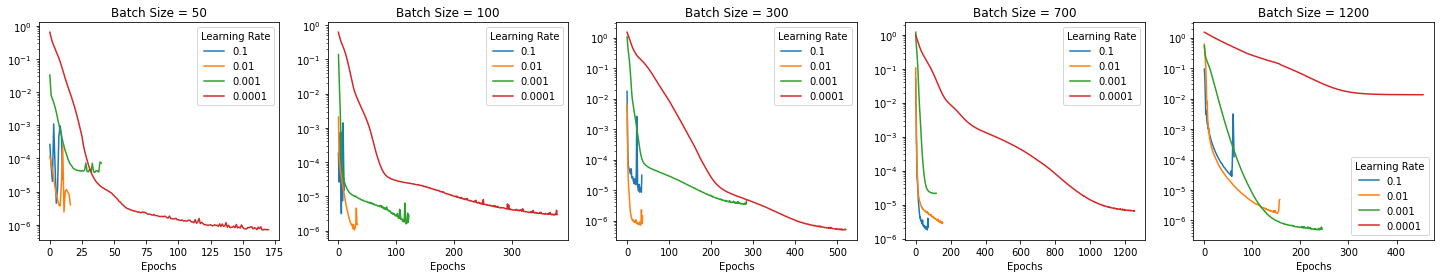

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(25,4))
for i, batch in enumerate([50, 100, 300, 700, 1200]):
    for h, learn in zip(np.array(hists).reshape((5,4))[i], [0.1, 0.01, 0.001, 0.0001]):
        axes[i].plot(h.history['val_loss'], label=learn)
        axes[i].set_title('Batch Size = {}'.format(batch))
        axes[i].set_yscale('log')
        axes[i].legend(title='Learning Rate')
        axes[i].set_xlabel('Epochs')